# Explainability of GNNs

In this Notebook the permutation and gradient based feature importance calculation is implemented.

In [38]:
import pandas as pd
import numpy as np
import torch
import yaml
import os
import sys
from tqdm import tqdm
from torch_geometric.loader import DataLoader

from models import *
from ensemble_train import create_model_from_config

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.size': 10})
plt.style.use('default')

sys.path.append('../utils')
import helpers

%matplotlib inline

## Load Ensemble and Data
## Config Files

In [15]:
ensemble_config = "experiments/large/best_GlobalInfo/config.yaml"

with open(ensemble_config, 'r') as config_file:
    config = yaml.safe_load(config_file)

save_path = os.path.dirname(ensemble_config)
name = "_".join(save_path.split("/")[-1:-3:-1])

## Load Data and Ensemble

In [16]:
# Use GPU
device = torch.device("cuda:1")

# Get Data from feather
print("Loading Data ...")
data = helpers.load_data(indexed=False)

if not os.path.exists("dist_matrix.npy"):
    print("Creating distance matrix ...")
    stations = helpers.load_stations(data)  # This needs to be done here because we need all stations
    dist_matrix = helpers.compute_dist_matrix(stations)
    np.save('dist_matrix.npy', dist_matrix)

# Clean Data
print("Cleaning Data ...")
data = helpers.clean_data(data, max_missing=121, max_alt=1000.0)

# Cut Dataset to only 2015 and 2016 (2016 wont be used anyway)
if "small" in name:
    data = data[data.date.dt.year >= 2015]

# Normalize Data
print("Normalizing Data ...")
normalized_data = helpers.normalize_data(data, last_obs=-len(data[data.date.dt.year == 2016]), method="max") #last_obs is -365 since the last year is used for testing

# Get List of stations with all stations -> will break further code if cut already
print("Extracting Stations ...")
stations = helpers.load_stations(data)


dist_matrix = np.load('dist_matrix.npy')
corr_matrix = np.load('corr_matrix.npy')
position_matrix = np.array(stations[['station', 'lon', 'lat']])


torch_data_test = []
for date in tqdm(data['date'].unique()[-365:], desc="Creating PyG Data"):
    torch_data_test.append(helpers.create_data(df=normalized_data,
                                               date=date,
                                               dist_matrix=dist_matrix if not config['data']['use_corr'] else corr_matrix,
                                               position_matrix=position_matrix,
                                               method=config['data']['method'],
                                               max_dist=config['data']['max_dist'],
                                               k=config['data']['nearest_k'],
                                               nearest_k_mode=config['data']['nearest_k_mode']))

# Move all the data directly to the GPU (should fit into memory)
# torch_data_train only contains training datat 2007-2015
torch_data_test = [tensor.to(device) for tensor in torch_data_test]

# Definition of train_loader and valid_loader
test_loader = DataLoader(torch_data_test, batch_size=8, shuffle=False)

def get_models_from_checkpoints():
    emb_num_features = torch_data_test[0].num_features + config['model']['embed_dim'] - 1

    model_list = []
    for snapshot in os.listdir(f"{os.path.dirname(ensemble_config)}/checkpoints"):
        path_to_snapshot = f"{os.path.dirname(ensemble_config)}/checkpoints/{snapshot}"
        config["model"]["compile"] = False  # Don't compile model
        model, optimizer, _ = create_model_from_config(config, emb_num_features, device)
        try:
            checkpoint = torch.load(path_to_snapshot)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device)
            model_list.append(model)
            print(f"Loaded {path_to_snapshot}")
        except Exception as e:
            print(e)
            print(f"could not load {path_to_snapshot}")
    return model_list

ensemble = get_models_from_checkpoints()

Loading Data ...
Cleaning Data ...
Normalizing Data ...
Extracting Stations ...


Creating PyG Data: 100%|██████████| 365/365 [00:05<00:00, 71.54it/s]


Loaded experiments/large/best_GlobalInfo/checkpoints/model_7.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_2.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_5.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_1.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_8.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_4.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_3.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_6.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_0.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_9.pt


## Evaluation Function

In [ ]:
def evaluate_ensemble(model_list, loader):
    mu_list_model = []
    sigma_list_model = []

    for model in model_list:
        mu_list_batch = []
        sigma_list_batch = []
        y_list = []
        ids_list = []

        for batch in loader:
            ids = batch.x[:, 0]
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            mu, sigma = torch.split(out, 1, dim=-1)
            y = batch.y
            y = y.cpu().numpy()
            y_list.append(y)
            ids = ids.cpu().numpy().flatten()
            ids_list.append(ids)

            mu = mu.detach().cpu().numpy().flatten()
            mu_list_batch.append(mu)
            sigma = sigma.detach().cpu().numpy().flatten()
            sigma_list_batch.append(sigma)


        mu = np.concatenate(mu_list_batch)
        mu_list_model.append(mu)
        sigma = np.concatenate(sigma_list_batch)
        sigma_list_model.append(sigma)
        y = np.concatenate(y_list)
        ids = np.concatenate(ids_list)
    mu = np.array(mu_list_model).T.mean(axis=1).reshape(-1,1)
    sigma = np.array(sigma_list_model).T.mean(axis=1).reshape(-1,1)
    ids = np.array(ids).T.flatten()

    mu = torch.tensor(mu).to(device)
    sigma = torch.tensor(sigma).to(device)
    preds = torch.cat([mu, sigma], dim=1)
    y = torch.tensor(y).to(device)
    err = crps(mu_sigma=preds, y=y)

    y = y.detach().cpu().numpy()
    mu = mu.detach().cpu().numpy()
    sigma = sigma.detach().cpu().numpy()
    return err

# Permutation Based Feature Importance

In [ ]:
feature_names = data.columns.drop(['date', 'obs'])

In [ ]:
# Store Results
f_imp = {}
reference = evaluate_ensemble(ensemble, test_loader).item()

for feature in tqdm(feature_names):
    # Copy Dataframe
    data_permute = normalized_data.copy()

    # Permute Feature
    shuffled_column = np.random.permutation(data_permute[feature])
    data_permute[feature] = shuffled_column

    # Create PyG data
    torch_data_test_perm = []
    for date in data['date'].unique()[-365:]:
        torch_data_test_perm.append(helpers.create_data(df=data_permute,
                                                        date=date,
                                                        dist_matrix=dist_matrix if not config['data']['use_corr'] else corr_matrix,
                                                        position_matrix=position_matrix,
                                                        method=config['data']['method'],
                                                        max_dist=config['data']['max_dist'],
                                                        k=config['data']['nearest_k'],
                                                        nearest_k_mode=config['data']['nearest_k_mode']))

    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    # Move all the data directly to the GPU (should fit into memory)
    torch_data_test_list = [tensor.to(device) for tensor in torch_data_test_perm]

    # Definition of train_loader and valid_loader
    test_loader_perm = DataLoader(torch_data_test_list, batch_size=8, shuffle=False)

    # Evaluate Model
    err = evaluate_ensemble(ensemble, test_loader_perm).item()

    # Store Results
    f_imp[feature] = err - reference


# Save Results in Dataframe
f_imp_saved = pd.read_csv("experiments/feature_importance.csv", index_col=0)
f_imp_saved = pd.concat([f_imp_saved, pd.DataFrame(f_imp, index=[name])])
f_imp_saved.to_csv('experiments/feature_importance.csv')

In [40]:
def plot_f_imp_together(path, save_path, factor, title="Feature Importance", rot=45, ha="right"):
    f_imp_saved = pd.read_csv(path, index_col=0)

    #Take absolute Value of the Dataframe -> the magnitude of attribution matters, not the sign
    f_imp_saved = f_imp_saved.abs()

    #Normalize
    f_imp_saved = f_imp_saved.div(f_imp_saved.sum(axis=1), axis=0)

    # Calculate the sum of each column
    column_sums = f_imp_saved.sum()

    # Sort the summed values in descending order and select the top 15 column names
    top_10_columns = column_sums.sort_values(ascending=False).head(15).index

    # Select the corresponding columns from the DataFrame
    df = f_imp_saved[top_10_columns]


    df = df.loc[["best_GraphSage_large", "best_ResGnn_large", "best_GlobalInfo_large"]]
    df["model"] = ["GraphSage", "ResGAT", "MPWGI"]
    if factor != 1:
        df["t2m_mean"] = df["t2m_mean"] / factor
        df.rename(columns={"t2m_mean": f"t2m_mean/{factor}"}, inplace=True)

    df.index = df.model

    df.rename(columns={"station": "embedding"}, inplace=True)

    vars = (*df.columns[:-1],)
    model_values = {key: (*v.values(),)[:-1] for key, v in df.T.to_dict().items()}

    x = np.arange(len(vars))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    plt.figure(figsize=(10, 6))

    colors = ["royalblue", "black", "crimson"]

    for (attribute, measurement), c in zip(model_values.items(),colors):
        offset = width * multiplier
        plt.bar(x + offset, measurement, width, label=attribute, color=c)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.ylabel('Relative Importance')
    plt.title(title)
    plt.xticks(x + width, vars)
    plt.xticks(rotation=rot, ha=ha)
    plt.legend()
    plt.savefig(save_path, format='pdf', dpi=600, bbox_inches='tight')

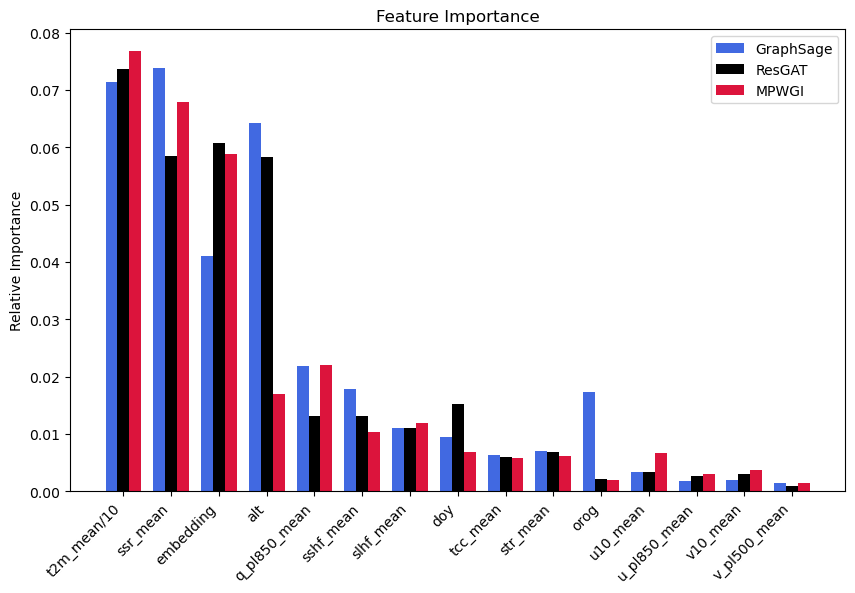

In [41]:
plot_f_imp_together("experiments/feature_importance.csv", "plots/feature_importance.pdf", 10, "Feature Importance")

# Explainability with PyG Explainers
All explainers implemented for Regression in PyG expect a 1-D output. So we will split the outputs of our model into 2 1-D outputs and explain them on their own.

In [4]:
from torch_geometric.explain import Explainer, ModelConfig, ThresholdConfig

In [22]:
# Define a new model that extracts the first dimension of the output
class ExtractDimEnsemble(torch.nn.Module):
    def __init__(self, original_ensemble, dim=None):
        super(ExtractDimEnsemble, self).__init__()
        self.ensemble = ModuleList(original_ensemble)
        self.dim = dim

    def forward(self, x, *args, **kwargs):
        # Forward pass through the original model
        preds_list = []
        for member in self.ensemble:
            preds_list.append(member(x, *args, **kwargs))

        preds_stacked = torch.stack(preds_list, dim=2)
        preds = torch.mean(preds_stacked, dim=2)

        # Slice the output
        if self.dim != None:
            return preds[:, self.dim]
        return preds

In [23]:
MuEnsemble = ExtractDimEnsemble(ensemble,0)
SigmaEnsemble = ExtractDimEnsemble(ensemble,1)

## Captum Explainer

In [25]:
from torch_geometric.explain import CaptumExplainer

In [ ]:
def explain_day(day, node_index, model):
    explainer = Explainer(
                model=model,
                algorithm=CaptumExplainer('IntegratedGradients'),
                explanation_type='model',
                model_config=ModelConfig(
                    mode='regression',
                    task_level='node',
                    return_type='raw',
                ),
                node_mask_type='attributes',
                edge_mask_type='object'
            )
    explanation = explainer(day.x.to(device),
                            day.edge_index.to(device),
                            edge_attr=day.edge_attr.to(device),
                            batch_id=torch.zeros(day.x.shape[0], dtype=torch.int64 ,device=device),
                            index=node_index)
    return explanation

def explain_test_set(ensemble):
    feature_names = data.columns.drop(['date', 'obs'])
    feature_importance = torch.zeros(len(feature_names)).to(device)

    for day in tqdm(torch_data_test):
        node_index = torch.arange(len(day.x), dtype=torch.int64)
        explanation = explain_day(day, node_index, ensemble)
        feature_importance += explanation.node_mask.sum(dim=0)

    return feature_importance, feature_names


def plot_feature_imp(feature_importance, feature_names, top_n=15, title="'Top 15 Feature Importances'"):
    feature_importances = feature_importance.detach().cpu().numpy()
    # Sort feature importances and names by importance
    sorted_indices = np.argsort(feature_importances)[::-1]  # Sort in descending order
    sorted_feature_importances = feature_importances[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]

    # Select the top 15 features
    top_feature_importances = sorted_feature_importances[:top_n]
    top_feature_names = sorted_feature_names[:top_n]

    # Create a bar plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.bar(top_feature_names, top_feature_importances, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")

def save_importance(f_imp, path):
    value, key = f_imp
    imp_dict = {key:value.item() for value, key in zip(value,key)}
    imp_df = pd.DataFrame(imp_dict, index=[name])
    # Load saved DF
    imp_saved = pd.read_csv(path, index_col=0)
    # Concat
    imp_saved = pd.concat([imp_saved, imp_df])
    # Save
    imp_saved.to_csv(path)

### $\mu$-Explainer

In [ ]:
MuImportance = explain_test_set(MuEnsemble)
save_importance(MuImportance, "experiments/feature_importance_mu.csv")
plot_feature_imp(*MuImportance, title="Top 15 Feature Importance for $\mu$")

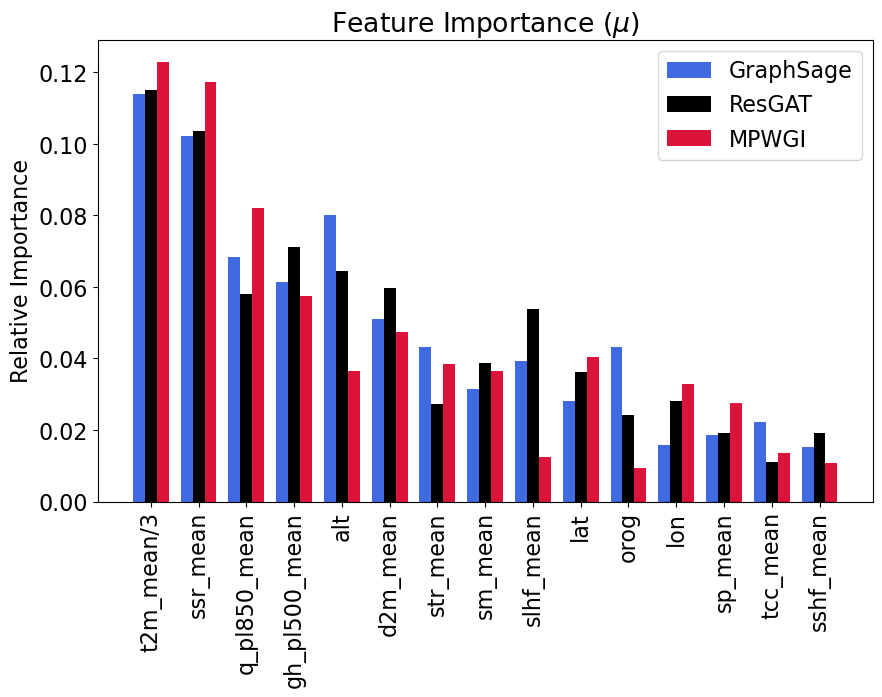

In [42]:
plt.rcParams.update({'font.size': 16})
plot_f_imp_together("experiments/feature_importance_mu.csv", "plots/feature_importance_mu.pdf", 3, "Feature Importance ($\mu$)", 90, "center")

In [ ]:
tmp = torch_data_test[-1]
explanation = explain_day(tmp, torch.tensor([0,1,2,3], dtype=torch.int64), MuEnsemble)

explanation.edge_mask = -explanation.edge_mask.detach()
helpers.visualize_explanation(subgraph=explanation,
                              fullgraph=tmp,
                              stations=stations)

### $\sigma$-Explainer

In [ ]:
SigmaImportance = explain_test_set(SigmaEnsemble)
save_importance(SigmaImportance, "experiments/feature_importance_sigma.csv")
plot_feature_imp(*SigmaImportance, title="Top 15 Feature Importance for $\mu$")

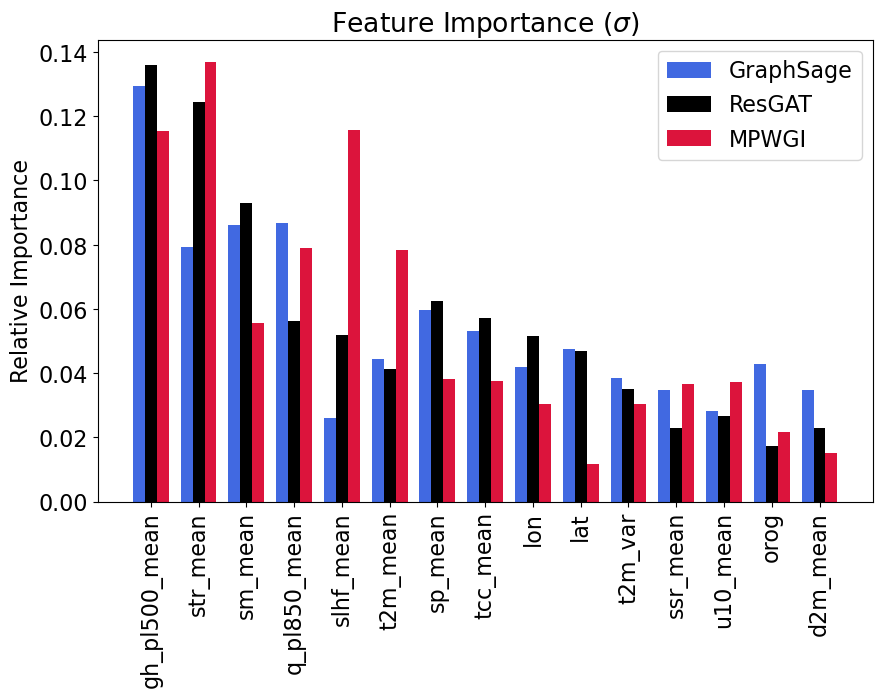

In [43]:
plot_f_imp_together("experiments/feature_importance_sigma.csv", "plots/feature_importance_sigma.pdf", 1, "Feature Importance ($\sigma$)",90, "center")

In [ ]:
tmp = torch_data_test[-1]
explanation = explain_day(tmp, torch.tensor([0,1,2,3], dtype=torch.int64), SigmaEnsemble)

explanation.edge_mask = explanation.edge_mask.detach()
helpers.visualize_explanation(subgraph=explanation,
                              fullgraph=tmp,
                              stations=stations)